In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
import shap
print(shap.__version__)
import matplotlib.pyplot as plt

shap.initjs()  # Cargar la biblioteca de JavaScript para las visualizaciones

d:\Adri Escritorio\Pycharm Projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.46.0


In [2]:
# Cargar el archivo CSV con punto y coma como delimitador
data = pd.read_csv('Cluster0ReadyToNN.csv', delimiter=';')

# Crear un diccionario para almacenar los objetos scaler por grupo
scalers = {}

# Iterar sobre los grupos únicos en Column15
for group in data['Column15'].unique():
    # Filtrar datos por grupo
    group_data = data[data['Column15'] == group]

    # Seleccionar las columnas para normalización (las 13 primeras)
    features = group_data.iloc[:, :13]

    # Normalizar los datos con MinMaxScaler
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(features)

    # Almacenar el scaler en el diccionario
    scalers[group] = scaler

    # Actualizar el DataFrame con los datos normalizados
    data.loc[data['Column15'] == group, 'Column1':'Column13'] = normalized_data


In [3]:
# Ordenar el DataFrame por 'Column 14' de forma ascendente
data = data.sort_values(by='Column14')

# Dividir los datos en entrenamiento (70%) y temporal (30%)
train_temp_data, test_data = train_test_split(data, test_size=0.3, stratify=data['Column15'], random_state=0)
#train_temp_data, test_data = train_test_split(data, test_size=0.3, shuffle=False, random_state=0)

# Dividir el temporal en entrenamiento (70%) y validación (30%)
train_data, validation_data = train_test_split(train_temp_data, test_size=0.3, stratify=train_temp_data['Column15'], random_state=0)
#train_data, validation_data = train_test_split(train_temp_data, test_size=0.3, shuffle=False, random_state=0)

# Separar características (X) y columna objetivo (y)
X_train_norm = train_data.iloc[:, :12]
y_train_norm = train_data['Column13']
X_val_norm = validation_data.iloc[:, :12]
y_val_norm = validation_data['Column13']
X_test_norm = test_data.iloc[:, :12]
y_test_norm = test_data['Column13']

In [4]:
data

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15
0,0.317757,0.163551,1.000000,0.957447,1.000000,0.750000,0.979167,0.708333,0.979167,1.000000,0.641026,0.897436,1.000000,2002/3,23
30078,0.164179,0.194030,0.138686,0.138686,0.109489,0.167883,0.160584,0.160584,0.160584,0.182482,0.153285,0.145985,0.167883,2002/3,10755
139428,0.042553,0.652482,0.836879,1.000000,0.295775,0.816901,0.295775,0.281690,0.492958,0.985915,0.436620,0.281690,0.535211,2002/3,49541
30024,0.203822,0.286624,0.159236,0.197452,0.178344,0.197452,0.140127,0.159236,0.210191,0.267516,0.248408,0.394904,1.000000,2002/3,10617
139482,0.000000,0.032000,0.016000,0.024000,0.032000,0.104000,0.352000,0.120000,0.048000,1.000000,0.825688,0.609091,0.054545,2002/3,49567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102221,0.047619,0.081633,0.156463,0.183673,0.115646,0.081633,0.299320,0.115646,0.095238,0.129252,0.129252,0.653061,0.319728,2015/4,35402
65879,0.119403,0.031716,0.041045,0.145522,0.078358,0.022388,0.024254,0.095149,0.067164,0.011194,0.035448,0.177239,0.082090,2015/4,22419
135863,0.091139,0.126582,0.162025,0.048101,0.106329,0.189873,0.164557,0.111392,0.098734,0.116456,0.147959,0.107143,0.087629,2015/4,47934
135755,0.028777,0.028777,0.050360,0.035971,0.035971,0.035971,0.043165,0.029197,0.000000,0.007299,0.021898,0.051095,0.007299,2015/4,47798


In [5]:
test_data.head(20)

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15
24905,0.222222,0.277778,0.265306,0.224490,0.367347,0.251701,1.000000,0.312925,0.292517,0.170068,0.209459,0.216216,0.128378,2005/2,8751
155320,0.228972,0.084112,0.049065,0.058411,0.144860,0.067757,0.058411,0.260870,0.335404,0.198758,0.149068,0.186335,0.347826,2006/3,56704
8745,0.114943,0.114943,0.103448,0.126437,0.126437,0.159420,0.150000,0.150000,0.083333,0.116667,0.103448,0.155172,0.051724,2015/2,3059
60462,0.307241,0.054264,0.032946,0.108527,0.300388,0.054264,0.031008,0.040698,0.253876,0.036320,0.019370,0.053269,0.295400,2011/3,20496
4241,0.162963,0.118519,0.177778,0.133333,0.118519,0.140741,0.140741,0.074074,0.103704,0.111111,0.918519,0.096296,0.155556,2009/4,1242
58407,0.142132,0.157360,0.182741,0.096447,0.131980,0.147208,0.131980,0.131980,0.126904,0.147208,0.126904,0.096939,0.091837,2010/4,19892
124215,0.038462,0.102564,0.166667,0.128205,0.128205,0.192308,0.179487,0.076923,0.051282,0.064103,0.128205,0.025641,0.012821,2006/2,43198
143532,0.000000,0.046154,0.015385,0.092308,0.061538,0.076923,0.000000,0.031250,0.062500,0.000000,0.000000,0.046875,0.062500,2002/3,51327
34430,0.080103,0.069767,0.056848,0.056848,0.095607,0.082687,0.058974,0.053846,0.105128,0.133333,0.074359,0.056410,0.061538,2010/3,12261
75228,0.209877,0.152263,0.259259,0.152091,0.190114,0.129278,0.045627,0.007605,0.019011,0.030418,0.326996,0.075269,0.046595,2004/1,25336


In [4]:
numFreezeLayers = 12 #12 para 12 training layers y 6 para 18 training layers

# Cargar el modelo preentrenado
model = load_model('modelTrainedv2.h5')

# Crear una nueva capa de entrada con 12 neuronas
nueva_capa_entrada = Input(shape=(12,))

# Construir un nuevo modelo que incluya la nueva capa de entrada
new_model = Sequential()
new_model.add(nueva_capa_entrada)

# Redimensionar la capa dense_1 para que sea compatible con 12 neuronas de entrada
# La capa dense_1 tenía inicialmente 30 unidades, se ajusta la matriz de pesos a (12, 30)
new_model.add(Dense(30, activation='tanh', input_shape=(12,), name="dense_update"))

# Agregar las capas restantes del modelo preentrenado (excluyendo la capa de entrada original)
for layer in model.layers[1:]:
    new_model.add(layer)

# Congelar las capas anteriores
for capa in new_model.layers[0:numFreezeLayers+1]:
    capa.trainable = False
    

# Agregar una nueva capa de salida con 1 neurona
new_model.add(Dense(1, activation='tanh'))

# Obtener las funciones de activación asignadas
activations = [layer.activation.__name__ for layer in new_model.layers]
print(activations)

# Obtener funciones de activación y entrenabilidad asignadas
layer_info = [layer.trainable for layer in new_model.layers]
print(layer_info)

# Definir el optimizador
optimizer = keras.optimizers.Adam(epsilon=1E-8, learning_rate=0.0005)

# Compilar el nuevo modelo y entrenarlo con tus datos
new_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_squared_error'])
new_model.summary()


early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear (en este caso, la pérdida en el conjunto de validación)
    patience=20,  # Número de épocas sin mejora antes de detener el entrenamiento
    min_delta=1E-4,  # Valor mínimo de mejora para considerar como una mejora significativa
    restore_best_weights=True  # Restaurar los mejores pesos del modelo cuando se detiene
)

['tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh']
[False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_update (Dense)        (None, 30)                390       
                                                                 
 dense_1 (Dense)             (None, 80)                2480      
                                                                 
 dense_2 (Dense)             (None, 90)                7290      
                                                                 
 dense_3 (Dense)             (None, 60)                5460      
       

In [5]:
row_test_to_shap = 88503
print(X_test_norm.loc[row_test_to_shap])

Column1     0.012730
Column2     0.018388
Column3     0.089552
Column4     0.089552
Column5     0.194030
Column6     0.327869
Column7     0.262295
Column8     0.213115
Column9     0.295082
Column10    0.344262
Column11    0.327869
Column12    0.557377
Name: 88503, dtype: float64


In [6]:
print(X_test_norm.loc[row_test_to_shap, :])

Column1     0.012730
Column2     0.018388
Column3     0.089552
Column4     0.089552
Column5     0.194030
Column6     0.327869
Column7     0.262295
Column8     0.213115
Column9     0.295082
Column10    0.344262
Column11    0.327869
Column12    0.557377
Name: 88503, dtype: float64


In [7]:
print(data.loc[row_test_to_shap])

Column1      0.01273
Column2     0.018388
Column3     0.089552
Column4     0.089552
Column5      0.19403
Column6     0.327869
Column7     0.262295
Column8     0.213115
Column9     0.295082
Column10    0.344262
Column11    0.327869
Column12    0.557377
Column13    0.377049
Column14      2015/2
Column15       30192
Name: 88503, dtype: object


In [8]:
# Extraer el valor de Column14
current_quarter = data.loc[row_test_to_shap, "Column14"]

# Separar año y trimestre
year, quarter = map(int, current_quarter.split('/'))

# Generar los trimestres en orden descendente
trimestres = []
year -= 3
quarter -= 1
for _ in range(len(data.columns)):  
    quarter += 1
    if quarter == 5:
        quarter = 1
        year += 1
    trimestres.append(f"{year}/{quarter}")

# Crear un nuevo DataFrame con los valores y los trimestres en columnas separadas
list_value_quarter = []

for i, col in enumerate(data.columns): 
    list_value_quarter.append({
        "Value": data.loc[row_test_to_shap, col],
        "Quarter": trimestres[i]
    })

# Convertir la lista de diccionarios en un DataFrame
df_value_quarter = pd.DataFrame(list_value_quarter)

# Cambiar el índice a Column1, Column2, ...
df_value_quarter.index = [f"Column{i+1}" for i in range(len(df_value_quarter))]
df_value_quarter.loc[df_value_quarter.index[13], "Quarter"] = np.nan  # O puedes usar None en lugar de np.nan
df_value_quarter.loc[df_value_quarter.index[14], "Quarter"] = np.nan  # O puedes usar None en lugar de np.nan

# Mostrar el nuevo DataFrame
print(df_value_quarter)

             Value Quarter
Column1    0.01273  2012/2
Column2   0.018388  2012/3
Column3   0.089552  2012/4
Column4   0.089552  2013/1
Column5    0.19403  2013/2
Column6   0.327869  2013/3
Column7   0.262295  2013/4
Column8   0.213115  2014/1
Column9   0.295082  2014/2
Column10  0.344262  2014/3
Column11  0.327869  2014/4
Column12  0.557377  2015/1
Column13  0.377049  2015/2
Column14    2015/2     NaN
Column15     30192     NaN


In [9]:
# Función de predicción para envolver el modelo de Keras
def model_predict(data):
    return new_model.predict(data)

# Elegir una muestra representativa de los datos de test
X_test_norm_sample = X_test_norm.sample(frac=0.1, random_state=0)

# Crear el explainer
explainer = shap.KernelExplainer(model_predict, X_test_norm_sample)

# Verificar el expected value
print("Expected value:", explainer.expected_value)

# Calcular los valores SHAP para una instancia específica
shap_values = explainer.shap_values(X_test_norm.loc[row_test_to_shap], nsamples=250)

# Verificar la forma de los valores SHAP
print("Número de elementos en shap_values:", len(shap_values))
print("Forma del primer elemento de shap_values:", shap_values[0].shape)

160/160 [==============================] - 1s 2ms/step


Using 5118 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Expected value: [0.00901646]
39985/39985 [==============================] - 67s 2ms/step
Número de elementos en shap_values: 12
Forma del primer elemento de shap_values: (1,)


In [10]:
shap_values

array([[-0.0067311 ],
       [-0.00389932],
       [ 0.01668704],
       [ 0.00048673],
       [ 0.        ],
       [-0.02194634],
       [ 0.        ],
       [ 0.        ],
       [ 0.04161206],
       [ 0.00438195],
       [ 0.00945963],
       [ 0.02652986]])

In [11]:
# Ver la forma actual de shap_values
print("Forma de shap_values antes de reshape:", shap_values.shape)

# Asegurar que shap_values tenga la forma correcta (1, num_features)
shap_values_reshaped = shap_values.squeeze(axis=-1)  # Elimina la dimensión extra

print("Forma de shap_values después de reshape:", shap_values_reshaped.shape)

# Asegurar que expected_value sea un escalar
if isinstance(explainer.expected_value, np.ndarray):
    expected_value = explainer.expected_value.item()
else:
    expected_value = explainer.expected_value

# Asegurar que X_train_norm tenga la forma correcta (1, num_features)
features = X_test_norm.loc[row_test_to_shap].values.reshape(1, -1)

# Generar el gráfico force_plot
shap.force_plot(expected_value, shap_values_reshaped, features)

Forma de shap_values antes de reshape: (12, 1)
Forma de shap_values después de reshape: (12,)


In [12]:
# Calcular los valores SHAP para varias instancias
shap_values = explainer.shap_values(X_test_norm_sample[0:25], nsamples=250)

# Verificar la forma de los valores SHAP
print("Número de elementos en shap_values:", len(shap_values))
print("Forma del primer elemento de shap_values:", shap_values[0].shape)

  0%|          | 0/25 [00:00<?, ?it/s]

39985/39985 [==============================] - 64s 2ms/step


  4%|▍         | 1/25 [01:17<31:02, 77.62s/it]

39985/39985 [==============================] - 63s 2ms/step


  8%|▊         | 2/25 [02:35<29:42, 77.50s/it]

39985/39985 [==============================] - 66s 2ms/step


 12%|█▏        | 3/25 [03:55<28:55, 78.90s/it]

39985/39985 [==============================] - 64s 2ms/step


 16%|█▌        | 4/25 [05:13<27:28, 78.49s/it]

39985/39985 [==============================] - 64s 2ms/step


 20%|██        | 5/25 [06:31<26:04, 78.23s/it]

39985/39985 [==============================] - 66s 2ms/step


 24%|██▍       | 6/25 [07:50<24:56, 78.75s/it]

39985/39985 [==============================] - 69s 2ms/step


 28%|██▊       | 7/25 [09:14<24:03, 80.22s/it]

39985/39985 [==============================] - 71s 2ms/step


 32%|███▏      | 8/25 [10:39<23:13, 81.95s/it]

39985/39985 [==============================] - 67s 2ms/step


 36%|███▌      | 9/25 [12:00<21:46, 81.68s/it]

39985/39985 [==============================] - 69s 2ms/step


 40%|████      | 10/25 [13:23<20:29, 81.97s/it]

39985/39985 [==============================] - 71s 2ms/step


 44%|████▍     | 11/25 [14:49<19:23, 83.10s/it]

39985/39985 [==============================] - 69s 2ms/step


 48%|████▊     | 12/25 [16:12<18:01, 83.16s/it]

39985/39985 [==============================] - 67s 2ms/step


 52%|█████▏    | 13/25 [17:33<16:29, 82.49s/it]

39985/39985 [==============================] - 68s 2ms/step


 56%|█████▌    | 14/25 [18:56<15:09, 82.66s/it]

39985/39985 [==============================] - 72s 2ms/step


 60%|██████    | 15/25 [20:22<13:57, 83.76s/it]

39985/39985 [==============================] - 69s 2ms/step


 64%|██████▍   | 16/25 [21:45<12:32, 83.56s/it]

39985/39985 [==============================] - 69s 2ms/step


 68%|██████▊   | 17/25 [23:08<11:07, 83.40s/it]

39985/39985 [==============================] - 69s 2ms/step


 72%|███████▏  | 18/25 [24:32<09:43, 83.39s/it]

39985/39985 [==============================] - 69s 2ms/step


 76%|███████▌  | 19/25 [25:55<08:20, 83.36s/it]

39985/39985 [==============================] - 70s 2ms/step


 80%|████████  | 20/25 [27:19<06:58, 83.63s/it]

39985/39985 [==============================] - 86s 2ms/step


 84%|████████▍ | 21/25 [29:57<07:02, 105.69s/it]

39985/39985 [==============================] - 164s 4ms/step


 88%|████████▊ | 22/25 [33:30<06:53, 137.91s/it]

39985/39985 [==============================] - 160s 4ms/step


 92%|█████████▏| 23/25 [36:59<05:18, 159.36s/it]

39985/39985 [==============================] - 163s 4ms/step


 96%|█████████▌| 24/25 [40:33<02:55, 175.68s/it]

39985/39985 [==============================] - 163s 4ms/step


100%|██████████| 25/25 [44:13<00:00, 106.13s/it]

Número de elementos en shap_values: 25
Forma del primer elemento de shap_values: (12, 1)


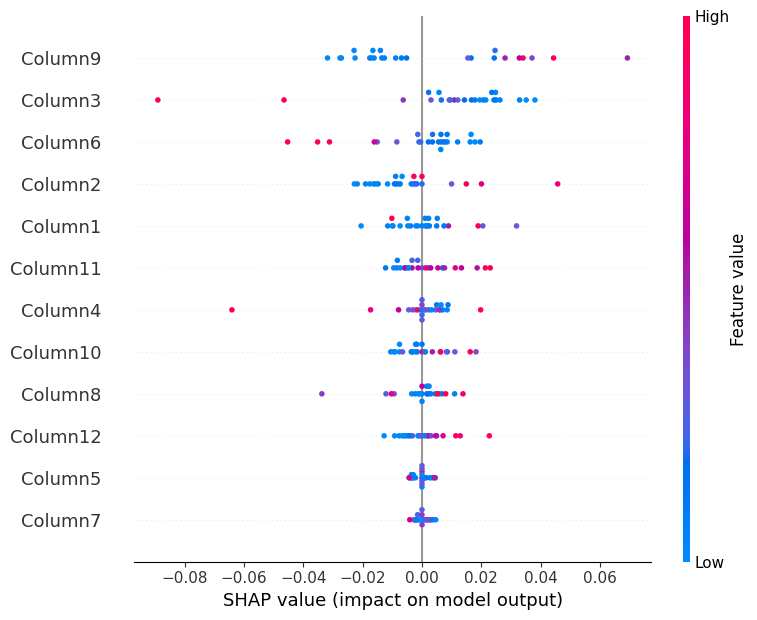

In [15]:
# Asegurar que shap_values tenga la misma forma que los datos
shap_values_reshaped = shap_values.squeeze(-1)  # De (10,12,1) a (10,12)

# Crear el summary plot
#plt.figure(figsize=(10, 6))
#shap.summary_plot(shap_values_reshaped, X_train_norm)

shap.summary_plot(shap_values_reshaped, X_test_norm_sample[0:25])